## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

__There are 294,478 rows in the dataset__

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

__There are 290,584 unique users in the dataset__

d. The proportion of users converted.

In [5]:
df.query('converted == 1').shape[0]/df.user_id.shape[0]

0.11965919355605512

In [6]:
df.drop_duplicates('user_id').converted.mean()

0.11956955647936569

__The proportion of users converted in the dataset is 12%__

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
new_control = df.query('landing_page == "new_page" and group == "control"').shape[0]
new_control
old_treatment = df.query('landing_page == "old_page" and group == "treatment"').shape[0]
old_treatment
mismatch = new_control + old_treatment
mismatch

3893

__The number of times that 'new_page' and 'treatment' don't match in the dataset is 3893__

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


__There are no missing values in any of the rows within the dataset__

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
i = df[((df.group == 'control') & (df.landing_page == 'new_page')) | ((df.group == 'treatment') & (df.landing_page == 'old_page'))].index
df2 = df.drop(i)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(subset=['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

__The row information for the repeat user_id is that the value for user_id is 773192, it has the value of treatment in the group column, new_page as the value for the landing_page column and is also a non-converted user.__

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates('user_id', inplace=True)
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.query('converted =="1"').user_id.nunique()/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
np.random.randint(2, size=290584).mean()

0.49955950774991054

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Based upon the results above, I can conclude that there is not sufficient evidence in saying that the new treatment page leads to more conversions. This conclusion comes from observing several facts based on the results:**

1. That there is a greater probability of individuals who do not convert, regardless of the page they receive
2. That more individuals within the control group, which simulates those who use the old page, are more likely to be converted than those in the treatment group, which simulates those who use the new page. 
3. The probability of someone receiving a new page is approximately 50%, which means it is completely unbiased and does not impact the outcome.

**Overall, this means that the new page does not lead to more user conversions than the old page** 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Regarding the question above, the null hypothesis could be that the difference between average user conversion rates for those who use the new pages and users who use the old pages is no different from zero. The alternative hypothesis would then be that the difference between the means is significantly higher than zero:** 

**H0:pnew−pold≤0**
  
**H1:pnew−pold>0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2['converted'].mean() 
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2['converted'].mean() 
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice(2, size=145310, p=[0.1196, 1 - 0.1196])
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice(2, size=145274, p=[0.1196, 1 - 0.1196])
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
p_new - p_old

0.0

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(2, size=145310, p=[0.1196, 1 - 0.1196])
    old_page_converted = np.random.choice(2, size=145274, p=[0.1196, 1 - 0.1196])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

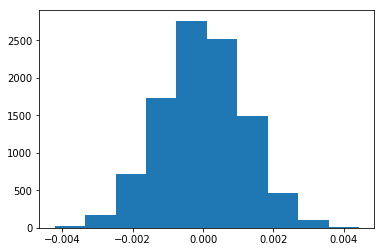

In [26]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
obs_diffs = df2.query('group =="treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
obs_diffs

-0.0015782389853555567

In [28]:
(p_diffs > obs_diffs).mean()

0.90329999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value computed above is the p-value. We acquired this value by computing the proportion of the simulation of 10,000 iterations (p_diffs) being greater than the sample mean observed in the actual dataset (obs_diffs). By finding the p-value to be 0.9, this means that we have failed to reject the null hypothesis and must conclude that there is no difference in user conversions between users who are exposed to the old pages and users who are exposed to the new pages.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2[(df2['landing_page']=="old_page")&(df2['converted']==1)].shape[0]
convert_new = df2[(df2['landing_page']=="new_page")&(df2['converted']==1)].shape[0]
n_old = df2[df2['landing_page']== "old_page"].shape[0]
n_new = df2[df2['landing_page']== "new_page"].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [30]:
convert_old

17489

In [31]:
convert_new

17264

In [32]:
n_old

145274

In [33]:
n_new

145310

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
from statsmodels.stats.proportion import proportions_ztest

counts = np.array([convert_old, convert_new]) 
nobs = np.array([n_old, n_new])
z_score, p_value = sm.stats.proportions_ztest(counts, nobs, alternative='smaller') 
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [35]:
from scipy.stats import norm

z_p_value = norm.cdf(z_score)

print(z_p_value)

critical_value_conf_interval = norm.ppf(.95)

print(critical_value_conf_interval)

0.905058312759
1.64485362695


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Using statsmodels, we also computed the p-value to be 0.9, which was similar to the previous computation of the p-value in an earlier question, which agrees with the initial conclusion of failing to reject the null hypothesis. As for the z-score, we computed it to be 1.31. To understand the significance of the z-score, we computed its significance to be 0.905 and computed the critical value of a 95% confidence interval above to be 1.644. This means that not only do we fail to reject the null hypothesis, we also have to conclude that the conversion rate for users exposed to the new pages is not statistically significant in comparison to users converted by being exposed to the old pages.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**In this case, we should be performing a logistic regression because there are only two possible outcomes to observe: whether a user is converted or not, which are both represented quantitatively.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [37]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2_new = df2
df2_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [38]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']] )
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-26 13:02 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with the ab_page variable is 0.19 (19%), which differs from our previous p-value that was acquired in the A/B testing approach. Since the null hypothesis would be that there is no difference in the number of user conversions between viewing the old page and viewing the new page, whereas the alternative hypothesis would be that the new page is greater than the old page in having more user conversions than the old page.** 

H0:pnew−pold=0

H1:pnew−pold≠0

**The p-value associated with ab_page in the logistic regression model is different from the one in the hypothesis testing of Part II because the logistic regression uses a two-tailed test for the coefficient of ab_page, that is, 
H0: coef of ab_page = 0; H1: coef of ab_page not = 0, and the z-test in Part II just uses one-tailed test, that is, H0: p_new > p_old; H1: p_new <= p_old.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is a good idea to consider other factors because the users in the dataset differ in various ways and those differences need to be taken into account to see how they impact the conversion from using the old pages to the new pages.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
dfc = pd.read_csv('countries.csv')
dfc.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
dfc[['US', 'UK', 'CA']] = pd.get_dummies(dfc['country'])
dfc_new = dfc
dfc_new.head()

,user_id,country,US,UK,CA
0,834778,UK,0,1,0
1,928468,US,0,0,1
2,822059,UK,0,1,0
3,711597,UK,0,1,0
4,710616,UK,0,1,0


In [42]:
df_all = dfc.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_all.head()

,country,US,UK,CA,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,,,
834778,UK,0,1,0,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,0,0,1,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,0,1,0,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,0,1,0,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,0,1,0,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [43]:
gm = sm.Logit(df_all['converted'], df_all[['intercept', 'ab_page', 'UK', 'CA']])
results2 = gm.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [44]:
results2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-26 13:02 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
CA             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

**According to the statistical results above, a user's country has no significant impact on conversion. This is determined by observing the p-values of the countries in the regression model which are 0.07 and 0.13 for UK and CA respectively. Both p-values are higher than the threshold level of 0.05, which means that there is no statistical significance of country having any impact on user conversion and that we failed to reject the null hypothesis, which stated that there is no difference between the influence of the new pages and the influence of the old pages in regards to user conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [45]:
df_all['CA_ab_page'] = df_all['CA'] * df_all['ab_page'] 
df_all['UK_ab_page'] = df_all['UK'] * df_all['ab_page']
df_all.head()

,country,US,UK,CA,timestamp,group,landing_page,converted,intercept,ab_page,CA_ab_page,UK_ab_page
user_id,,,,,,,,,,,,
834778,UK,0,1,0,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
928468,US,0,0,1,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,0,1,0,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,0,1,0,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
710616,UK,0,1,0,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [47]:
lm3 = sm.Logit(df_all['converted'], df_all[['intercept', 'ab_page','UK','CA', 'CA_ab_page', 'UK_ab_page']])
res = lm3.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-26 13:05 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
CA             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
CA_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

**From the previous regression model, we found that a user's country does not have any impact on user conversion when exposed to the old or new pages. In other words, we failed to reject the null hypothesis and must believe that there is no difference between the influence of the new pages and the influence of the old pages in regards to user conversion, even when we took a user's country into consideration. In this regression model, we took the interaction of the pages and countries into account, represented as CA_ab_page and UK_ab_page. According to the p-values in the summary, CA_ab_page is 0.39 (39%) and UK_ab_page is 0.17 (17%). Both of these values exceed the 5% threshold level of statistical significance, which means that even with the interaction between page and country, there is no significant effect on conversion.**

In [2]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0